<a href="https://colab.research.google.com/github/rajashekar/colab/blob/main/MLE_Samsung_Research_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Today you are a MLE@Samsung Research and your goal is to perform segmentation of cystic regions from OCT images.
## This work is based on the recent publication https://arxiv.org/abs/2008.02952
## This model is adapted from the original codebase in https://github.com/sohiniroych/U-net_using_TF2

# Optical Coherence Tomography (OCT) images represent grayscale images representing the depth of retina. Cystic regions are gaps in the retina as shown below
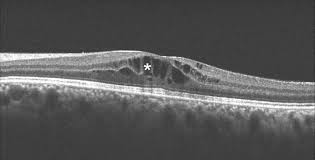

## Yor goal is to segment the cysts (dark gaps) in the images using the U-net model.

# Your Deliverables are as follows:
### 1. Train a u-net model from scratch and test performance on test images for 2 OCT repos.
### 2. Vary the loss function, kernel dialation, depthwise separable kernels and report results.
### 3. Report observations with and without Batch normalization and Dropout at test time.
### 4. If you use Dropout at test time and generate 2-3 test predictions, what do you observe from these predictions? 

# Task 1: Implement U-net model from scratch for the 'cirrus_3' data set. Report performance on test set and save the model as 'unet_cirrus.hdf5'
## [Instructor Led]

## Lets start by stepwise defining all libraries and functions needed to generate the model and pre-process the data

In [1]:
#Step 1: Load libraries for the U-net Model
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
#from tensorflow import keras
import tensorflow as tf

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import skimage.io as io
import skimage.transform as trans
import matplotlib.pyplot as plt
import scipy.misc as sc

In [3]:
#Define Additional loss functions for Task 2
def dice_coef(y_true, y_pred, smooth=1):
    intersection = keras.sum(y_true * y_pred, axis=[1,2,3])
    union = keras.sum(y_true, axis=[1,2,3]) + keras.sum(y_pred, axis=[1,2,3])
    return keras.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [4]:
# 3x3 kernels, binary cross entropy loss
def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = tf.keras.Input(shape=input_size)
    conv1 = Conv2D(64, 3, activation = 'relu',padding = 'same', kernel_initializer = 'he_normal')(inputs) #dialation_rate=2 etc.
    #[Try DepthwiseConv2D instead of Conv2D for depthwise separable filters]
    conv1 = BatchNormalization()(conv1)
    #[Try removing BatchNormalization and see performance]
    conv1 = Conv2D(64, 3, activation = 'relu',padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)#training=True will enable dropout for test data
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))

    merge6 = concatenate([drop4,up6], axis = 3)

    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))

    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
   
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = tf.keras.Model(inputs = inputs, outputs = conv10)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = 'accuracy')
    # Modify loss function above to dice_coef_loss defined above, and metrics to dice_coef
    

    if(pretrained_weights):
    	model=keras.models.load_model(pretrained_weights)

    return model

In [48]:
#Step 2: Define the U-net model
# 5x5 dialated kernels with cross entropy loss
def unet_5(pretrained_weights = None,input_size = (256,256,1)):
    inputs = tf.keras.Input(shape=input_size)
    conv1 = Conv2D(64, 5, activation = 'relu',padding = 'same', kernel_initializer = 'he_normal')(inputs) #dialation_rate=2 etc.
    #[Try DepthwiseConv2D instead of Conv2D for depthwise separable filters]
    conv1 = BatchNormalization()(conv1)
    #[Try removing BatchNormalization and see performance]
    conv1 = Conv2D(64, 5, activation = 'relu',padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', dilation_rate=2)(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', dilation_rate=2)(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', dilation_rate=2)(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', dilation_rate=2)(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', dilation_rate=2)(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', dilation_rate=2)(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)#training=True will enable dropout for test data
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', dilation_rate=2)(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', dilation_rate=2)(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))

    merge6 = concatenate([drop4,up6], axis = 3)

    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))

    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
   
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = tf.keras.Model(inputs = inputs, outputs = conv10)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = 'accuracy')
    # model.compile(optimizer = Adam(lr = 1e-4), loss = dice_coef_loss, metrics = dice_coef)
    # Modify loss function above to dice_coef_loss defined above, and metrics to dice_coef
    

    if(pretrained_weights):
    	model=keras.models.load_model(pretrained_weights)

    return model

In [6]:
# depthwise seperable kernels, dice coef loss
def unet_5_depth(pretrained_weights = None,input_size = (256,256,1)):
    inputs = tf.keras.Input(shape=input_size)
    conv1 = SeparableConv2D(64, 5, activation = 'relu',padding = 'same', kernel_initializer = 'he_normal', dilation_rate=2)(inputs) #dialation_rate=2 etc.
    #[Try DepthwiseConv2D instead of Conv2D for depthwise separable filters]
    conv1 = BatchNormalization()(conv1)
    #[Try removing BatchNormalization and see performance]
    conv1 = SeparableConv2D(64, 5, activation = 'relu',padding = 'same', kernel_initializer = 'he_normal', dilation_rate=2)(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = SeparableConv2D(128, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', dilation_rate=2)(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = SeparableConv2D(128, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', dilation_rate=2)(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = SeparableConv2D(256, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', dilation_rate=2)(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = SeparableConv2D(256, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', dilation_rate=2)(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = SeparableConv2D(512, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', dilation_rate=2)(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = SeparableConv2D(512, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', dilation_rate=2)(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)#training=True will enable dropout for test data
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = SeparableConv2D(1024, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', dilation_rate=2)(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = SeparableConv2D(1024, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', dilation_rate=2)(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))

    merge6 = concatenate([drop4,up6], axis = 3)

    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))

    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
   
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = tf.keras.Model(inputs = inputs, outputs = conv10)
    model.compile(optimizer = Adam(lr = 1e-4), loss = dice_coef_loss, metrics = dice_coef)
    # Modify loss function above to dice_coef_loss defined above, and metrics to dice_coef
    

    if(pretrained_weights):
    	model=keras.models.load_model(pretrained_weights)

    return model

In [7]:
!nvidia-smi

Mon Jul 26 23:12:11 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
%cd /content/gdrive/MyDrive/Colab/Fourth.Brain/Samsung_OCT/

/content/gdrive/MyDrive/Colab/Fourth.Brain/Samsung_OCT


In [10]:
#All additional functions for data prep and evaluation are housed in unet_helper_finctions.py
from unet_helper_functions import *

## All definitions are now done! Lets start using the functions now...
## B. Call to image data generator, model initialization, followed by model fitting.

__You can use the following code to unzip Data if you haven't done so__

In [22]:
!unzip Data.zip -d /content

Archive:  Data.zip
   creating: /content/Data/
   creating: /content/Data/cirrus_3/
   creating: /content/Data/cirrus_3/train/
   creating: /content/Data/cirrus_3/train/Image/
  inflating: /content/Data/cirrus_3/train/Image/bscan_100.jpg  
  inflating: /content/Data/cirrus_3/train/Image/bscan_101.jpg  
  inflating: /content/Data/cirrus_3/train/Image/bscan_102.jpg  
  inflating: /content/Data/cirrus_3/train/Image/bscan_103.jpg  
  inflating: /content/Data/cirrus_3/train/Image/bscan_104.jpg  
  inflating: /content/Data/cirrus_3/train/Image/bscan_122.jpg  
  inflating: /content/Data/cirrus_3/train/Image/bscan_105.jpg  
  inflating: /content/Data/cirrus_3/train/Image/bscan_106.jpg  
  inflating: /content/Data/cirrus_3/train/Image/bscan_107.jpg  
  inflating: /content/Data/cirrus_3/train/Image/bscan_108.jpg  
  inflating: /content/Data/cirrus_3/train/Image/bscan_109.jpg  
  inflating: /content/Data/cirrus_3/train/Image/bscan_110.jpg  
  inflating: /content/Data/cirrus_3/train/Image/bscan_11

In [23]:
#Step 1: Call to image data generator in keras
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=[0.7,1],
                    horizontal_flip=True,
                    fill_mode='nearest')
PATH='/content/Data/cirrus_3/train/'

In [24]:
if not os.path.exists(PATH+'aug'):
    os.makedirs(PATH+'aug')
    
if not os.path.exists('/content/Data/cirrus_3/test/'+'pred'):
    os.makedirs('/content/Data/cirrus_3/test/'+'pred')

# the trainGenerator function is defined in the helpers file  
data_gen = trainGenerator(10,PATH,'Image','GT',data_gen_args, save_to_dir = PATH+'aug')

In [13]:
# 3x3 kernels, binary cross entropy loss
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       batch_normalization[0][0]        
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [49]:
# 5x5 dialated kernels with cross entropy loss
model_5 = unet_5()
model_5.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_62 (Conv2D)              (None, 256, 256, 64) 1664        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_30 (BatchNo (None, 256, 256, 64) 256         conv2d_62[0][0]                  
__________________________________________________________________________________________________
conv2d_63 (Conv2D)              (None, 256, 256, 64) 102464      batch_normalization_30[0][0]     
____________________________________________________________________________________________

In [16]:
# depthwise seperable kernels, dice coef loss
model_5_depth = unet_5_depth()
model_5_depth.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 256, 256, 64) 153         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 256, 256, 64) 256         separable_conv2d[0][0]           
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 256, 256, 64) 5760        batch_normalization_20[0][0]     
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [18]:
#Step 3: Initialize Tensorboard to monitor changes in Model Loss 
import datetime
%load_ext tensorboard

# if you don't have the logs folder, make sure you create one:
os.removedirs('logs/fit')
os.makedirs('logs/fit/')

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [19]:
%ls

 Data/      logs/                            __pycache__/
 Data.zip  'MLE@Samsung_Research_v1.ipynb'   unet_helper_functions.py


In [25]:
#Step 4: Fit the u-net model
#model_checkpoint = tf.keras.callbacks.ModelCheckpoint('unet_cirrus.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit(data_gen,steps_per_epoch=15,epochs=50,verbose=1)#callbacks=[tensorboard_callback])
# you can load the saved model using:
#model.load_weights('unet_cirrus.hdf5')

Found 91 images belonging to 1 classes.
Found 91 images belonging to 1 classes.
Epoch 1/50
15/15 [==============================] - 29s 416ms/step - loss: 0.1902 - accuracy: 0.9515
Epoch 2/50
15/15 [==============================] - 5s 328ms/step - loss: 0.0845 - accuracy: 0.9489
Epoch 3/50
15/15 [==============================] - 5s 352ms/step - loss: 0.0729 - accuracy: 0.9498
Epoch 4/50
15/15 [==============================] - 5s 329ms/step - loss: 0.0681 - accuracy: 0.9502
Epoch 5/50
15/15 [==============================] - 5s 352ms/step - loss: 0.0677 - accuracy: 0.9707
Epoch 6/50
15/15 [==============================] - 5s 329ms/step - loss: 0.0670 - accuracy: 0.9781
Epoch 7/50
15/15 [==============================] - 5s 350ms/step - loss: 0.0647 - accuracy: 0.9790
Epoch 8/50
15/15 [==============================] - 5s 328ms/step - loss: 0.0625 - accuracy: 0.9802
Epoch 9/50
15/15 [==============================] - 5s 350ms/step - loss: 0.0626 - accuracy: 0.9804
Epoch 10/50
15/15 [

In [50]:
model_5.fit(data_gen,steps_per_epoch=15,epochs=50,verbose=1)#callbacks=[tensorboard_callback])

Epoch 1/50
15/15 [==============================] - 10s 486ms/step - loss: 0.2079 - accuracy: 0.9516
Epoch 2/50
15/15 [==============================] - 7s 461ms/step - loss: 0.0787 - accuracy: 0.9475
Epoch 3/50
15/15 [==============================] - 7s 483ms/step - loss: 0.0692 - accuracy: 0.9496
Epoch 4/50
15/15 [==============================] - 7s 459ms/step - loss: 0.0690 - accuracy: 0.9482
Epoch 5/50
15/15 [==============================] - 7s 482ms/step - loss: 0.0658 - accuracy: 0.9494
Epoch 6/50
15/15 [==============================] - 7s 459ms/step - loss: 0.0645 - accuracy: 0.9758
Epoch 7/50
15/15 [==============================] - 7s 481ms/step - loss: 0.0619 - accuracy: 0.9794
Epoch 8/50
15/15 [==============================] - 7s 458ms/step - loss: 0.0673 - accuracy: 0.9782
Epoch 9/50
15/15 [==============================] - 7s 481ms/step - loss: 0.0628 - accuracy: 0.9789
Epoch 10/50
15/15 [==============================] - 7s 460ms/step - loss: 0.0624 - accuracy: 0.979

In [27]:
model_5_depth.fit(data_gen,steps_per_epoch=15,epochs=50,verbose=1)#callbacks=[tensorboard_callback])

Epoch 1/50
15/15 [==============================] - 11s 559ms/step - loss: -0.1583 - dice_coef: 0.1574
Epoch 2/50
15/15 [==============================] - 8s 520ms/step - loss: -0.3022 - dice_coef: 0.3083
Epoch 3/50
15/15 [==============================] - 8s 548ms/step - loss: -0.4153 - dice_coef: 0.4164
Epoch 4/50
15/15 [==============================] - 8s 522ms/step - loss: -0.4350 - dice_coef: 0.4135
Epoch 5/50
15/15 [==============================] - 8s 548ms/step - loss: -0.4578 - dice_coef: 0.4529
Epoch 6/50
15/15 [==============================] - 8s 522ms/step - loss: -0.4640 - dice_coef: 0.4682
Epoch 7/50
15/15 [==============================] - 8s 548ms/step - loss: -0.4685 - dice_coef: 0.4551
Epoch 8/50
15/15 [==============================] - 8s 521ms/step - loss: -0.4764 - dice_coef: 0.4808
Epoch 9/50
15/15 [==============================] - 8s 547ms/step - loss: -0.4810 - dice_coef: 0.4854
Epoch 10/50
15/15 [==============================] - 8s 520ms/step - loss: -0.486

In [51]:
#%tensorboard --logdir logs/fit

## C. Run the trained model on test images and save the outputs, and evaluate pixel-level segmentation performance 

In [29]:
import warnings
warnings.filterwarnings('ignore')

#Step 1: Run model on test images and save the images
#number of test images
n_i=len(os.listdir('/content/Data/cirrus_3/test/Image/'))
#Call test generator
test_gen = testGenerator('/content/Data/cirrus_3/test/Image/')
#Return model outcome for each test image
results = model.predict(test_gen,n_i,verbose=1)
#If dropout is activated for test data, then calling this function multiple times will generate difefrent outputs!
saveResult('/content/Data/cirrus_3/test/Image/','/content/Data/cirrus_3/test/pred/',results)

48/48 [==============================] - 1s 16ms/step


['/content/Data/cirrus_3/train/Image/bscan_81.jpg']


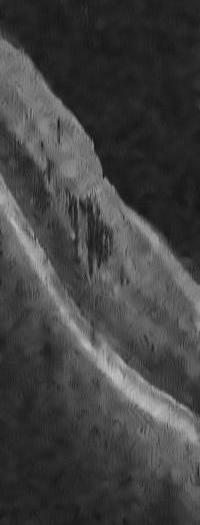

In [37]:
# checking the train image
train_image = !find /content/Data/cirrus_3/train/Image -name *.jpg | head -1
print(train_image)

from IPython.display import Image
Image(filename=train_image[0])

['/content/Data/cirrus_3/train/GT/bscan_81.jpg']


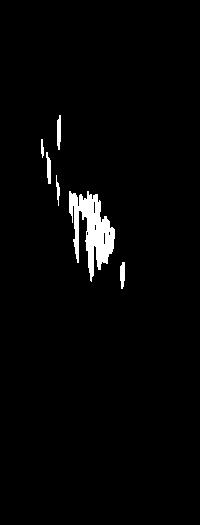

In [38]:
train_gt = !find /content/Data/cirrus_3/train/GT -name *.jpg | head -1
print(train_gt)
Image(filename=train_gt[0])

['/content/Data/cirrus_3/test/pred/bscan_186.jpg_predict.png']


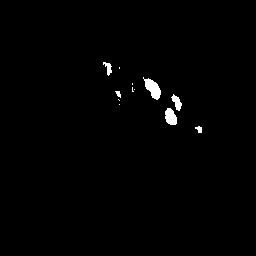

In [39]:
test_pred = !find /content/Data/cirrus_3/test/pred -name *.png | head -1
print(test_pred)
Image(filename=test_pred[0])

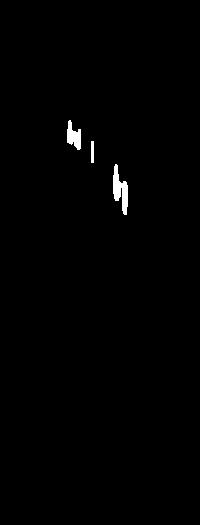

In [45]:
# checking actual test image of above
Image(filename='/content/Data/cirrus_3/test/GT/bscan_186.jpg')

In [40]:
gt_path='/content/Data/cirrus_3/test/GT/'
evalResult(gt_path,results)

Precision= 0.27469031695923035 Recall= 0.679474248168373 IoU= 0.23430738019816832 acc= 0.9865452448527018 F1= 0.3482422782063608


In [52]:
!rm -rf /content/Data/cirrus_3/test/pred_5
!mkdir /content/Data/cirrus_3/test/pred_5

In [53]:
#number of test images
n_i=len(os.listdir('/content/Data/cirrus_3/test/Image/'))
#Call test generator
test_gen = testGenerator('/content/Data/cirrus_3/test/Image/')
results_5 = model_5.predict(test_gen,n_i,verbose=1)
#If dropout is activated for test data, then calling this function multiple times will generate difefrent outputs!
saveResult('/content/Data/cirrus_3/test/Image/','/content/Data/cirrus_3/test/pred_5/',results_5)#Step 2: Evaluate the predicted outcome

48/48 [==============================] - 2s 35ms/step


In [54]:
#Step 2: Evaluate the predicted outcome
evalResult(gt_path,results_5)

Precision= 0.24800096318002585 Recall= 0.7175201154933775 IoU= 0.22040214199812624 acc= 0.9856348037719727 F1= 0.33739693823569045


In [55]:
#number of test images
n_i=len(os.listdir('/content/Data/cirrus_3/test/Image/'))
#Call test generator
test_gen = testGenerator('/content/Data/cirrus_3/test/Image/')
results_5_depth = model_5_depth.predict(test_gen,n_i,verbose=1)
#If dropout is activated for test data, then calling this function multiple times will generate difefrent outputs!
saveResult('/content/Data/cirrus_3/test/Image/','/content/Data/cirrus_3/test/pred_5_depth/',results_5_depth)#Step 2: Evaluate the predicted outcome

48/48 [==============================] - 1s 17ms/step


In [56]:
#Step 2: Evaluate the predicted outcome
evalResult(gt_path,results_5_depth)

Precision= nan Recall= 0.3445278510239875 IoU= 0.22370020805006885 acc= 0.9929924011230469 F1= 0.33165893710988825


# Task 2: For unet model definition, vary the following 
# Tip: (Divide and conquer for solving these tasks at Breakout!):
## 1. Kernels (dialated kernels), 
## 2. Separable filters. Check syntax at: (https://www.tensorflow.org/api_docs/python/tf/keras/layers/DepthwiseConv2D)
## 3. Loss function (to dice coefficient) and rerun whole process. Does it improve test performance?
### Enter your results in the table below

| U-net Parameters  (cirrus_3) | Precision|Recall|IoU|acc |F1 |
| - | - | - | - | - | - |
| 3x3 kernels, binary cross entropy loss|0.27|0.67|0.23|0.98|0.34|
| 5x5 dilated kernels,cross-entropy loss|0.24|0.71|0.22|0.98|0.33|
| 5x5, separable kernels,dice_coef loss |nan|0.34|0.22|0.99|0.33|


## Save the model with "best" performance above as unet_cirrus3.hdf5 model!

In [62]:
model.save('unet_cirrus3.h5')

# Task 3: Perform transfer learning with 'unet_cirrus3.hdf5' as base weights and retrain on the 'nidek1' data set. Your training should take fewer epochs now. Report performace using 3x3 kernels with cross entropy loss.

### Hint: To load a previously save model that has custom loss functions use the following commands:

from tensorflow.keras.models import load_model

dependencies = {
    'dice_coef_loss': dice_coef_loss
}

model=load_model('unet_cirrus3.hdf5',custom_objects=dependencies)

In [73]:
# load_model
base_model = tf.keras.models.load_model('unet_cirrus3.h5')

In [74]:
# freeze layers of the model
for layer in base_model.layers[:-3]:
  layer.trainable = False

In [75]:
#Create new model
new_model = tf.keras.Sequential([tf.keras.Input(shape=(256,256,1)), base_model])

In [76]:
new_model.compile(optimizer = Adam(lr = 1e-3), loss = 'binary_crossentropy', metrics = 'accuracy')

In [77]:
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 256, 256, 1)       31047557  
Total params: 31,047,557
Trainable params: 38,085
Non-trainable params: 31,009,472
_________________________________________________________________


In [78]:
# create data pipelines
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=[0.7,1],
                    horizontal_flip=True,
                    fill_mode='nearest')
PATH='/content/Data/nidek_1/train/'

In [79]:
if not os.path.exists(PATH+'aug'):
    os.makedirs(PATH+'aug')
    
if not os.path.exists('/content/Data/nidek_1/test/'+'pred'):
    os.makedirs('/content/Data/nidek_1/test/'+'pred')    
data_gen = trainGenerator(10,PATH,'Image','GT',data_gen_args, save_to_dir = PATH+'aug')

In [80]:
# Initialize Tensorboard to monitor changes in Model Loss 
import datetime
%load_ext tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [81]:
# custom callback for stopping at a certain accuracy
class mycallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.97):
            print("\nReached 97% accuracy so cancelling training!")
            self.model.stop_training = True

stop_train = mycallback()

In [82]:
new_model.fit(data_gen, steps_per_epoch=15,epochs=50,verbose=1, callbacks=[tensorboard_callback, stop_train])

Found 23 images belonging to 1 classes.
Found 23 images belonging to 1 classes.
Epoch 1/50
15/15 [==============================] - 5s 284ms/step - loss: 0.1176 - accuracy: 0.9405
Epoch 2/50
15/15 [==============================] - 2s 156ms/step - loss: 0.0792 - accuracy: 0.9762

Reached 97% accuracy so cancelling training!


In [83]:
new_model.save('unet_nidek.h5')

In [84]:
# Run model on test images and save the images
# number of test images
n_i=len(os.listdir('/content/Data/nidek_1/test/Image/'))
# Call test generator
test_gen = testGenerator('/content/Data/nidek_1/test/Image/')
# Return model outcome for each test image
results = new_model.predict_generator(test_gen,n_i,verbose=1)

saveResult('/content/Data/nidek_1/test/Image/','/content/Data/nidek_1/test/pred/',results)

30/30 [==============================] - 1s 16ms/step


['/content/Data/nidek_1/test/pred/bscan_77.jpg_predict.png']


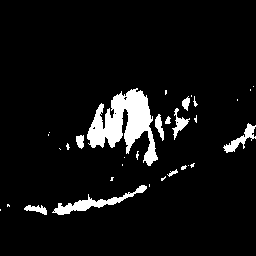

In [85]:
test_pred = !find /content/Data/nidek_1/test/pred -name *.png | head -1
print(test_pred)
Image(filename=test_pred[0])

# Task 4: Analyze the importance of BatchNormalization:
## For the Nidek1 dataset, remove all BatchNormalization commands and test the model.
## Next, add more batch normalizations after each conv2D layer for decoder networks and test the model.
## Report how useful Batchnormalization is.



In [100]:
# 3x3 kernels, binary cross entropy loss
def unet_no_batch(pretrained_weights = None,input_size = (256,256,1)):
    inputs = tf.keras.Input(shape=input_size)
    conv1 = Conv2D(64, 3, activation = 'relu',padding = 'same', kernel_initializer = 'he_normal')(inputs) #dialation_rate=2 etc.
    #[Try DepthwiseConv2D instead of Conv2D for depthwise separable filters]
    #[Try removing BatchNormalization and see performance]
    conv1 = Conv2D(64, 3, activation = 'relu',padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)#training=True will enable dropout for test data
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))

    merge6 = concatenate([drop4,up6], axis = 3)

    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))

    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
   
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = tf.keras.Model(inputs = inputs, outputs = conv10)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = 'accuracy')
    # Modify loss function above to dice_coef_loss defined above, and metrics to dice_coef
    

    if(pretrained_weights):
    	model=keras.models.load_model(pretrained_weights)

    return model

In [101]:
model_no_batch = unet_no_batch()

In [102]:
model_no_batch.fit(data_gen, steps_per_epoch=15,epochs=50,verbose=1, callbacks=[tensorboard_callback, stop_train])

Epoch 1/50
 6/15 [===========>..................] - ETA: 4s - loss: 0.3915 - accuracy: 0.9051WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.2464s vs `on_train_batch_end` time: 0.2466s). Check your callbacks.


15/15 [==============================] - 7s 383ms/step - loss: 0.2998 - accuracy: 0.9485
Epoch 2/50
15/15 [==============================] - 4s 294ms/step - loss: 0.1317 - accuracy: 0.9755

Reached 97% accuracy so cancelling training!


In [103]:
# 3x3 kernels, binary cross entropy loss
def unet_more_batches(pretrained_weights = None,input_size = (256,256,1)):
    inputs = tf.keras.Input(shape=input_size)
    conv1 = Conv2D(64, 3, activation = 'relu',padding = 'same', kernel_initializer = 'he_normal')(inputs) #dialation_rate=2 etc.
    #[Try DepthwiseConv2D instead of Conv2D for depthwise separable filters]
    conv1 = BatchNormalization()(conv1)
    #[Try removing BatchNormalization and see performance]
    conv1 = Conv2D(64, 3, activation = 'relu',padding = 'same', kernel_initializer = 'he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)#training=True will enable dropout for test data
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))

    merge6 = concatenate([drop4,up6], axis = 3)

    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))

    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)
   
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = tf.keras.Model(inputs = inputs, outputs = conv10)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = 'accuracy')
    # Modify loss function above to dice_coef_loss defined above, and metrics to dice_coef
    

    if(pretrained_weights):
    	model=keras.models.load_model(pretrained_weights)

    return model

In [105]:
model_more_batches = unet_more_batches()

In [106]:
model_more_batches.fit(data_gen, steps_per_epoch=15,epochs=50,verbose=1, callbacks=[tensorboard_callback, stop_train])

Epoch 1/50
 6/15 [===========>..................] - ETA: 4s - loss: 0.8385 - accuracy: 0.5502WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1225s vs `on_train_batch_end` time: 0.2559s). Check your callbacks.


15/15 [==============================] - 7s 361ms/step - loss: 0.7476 - accuracy: 0.6283
Epoch 2/50
15/15 [==============================] - 5s 323ms/step - loss: 0.6284 - accuracy: 0.8004
Epoch 3/50
15/15 [==============================] - 5s 320ms/step - loss: 0.5929 - accuracy: 0.9255
Epoch 4/50
15/15 [==============================] - 5s 326ms/step - loss: 0.5801 - accuracy: 0.9511
Epoch 5/50
15/15 [==============================] - 5s 327ms/step - loss: 0.5724 - accuracy: 0.9621
Epoch 6/50
15/15 [==============================] - 5s 324ms/step - loss: 0.5682 - accuracy: 0.9708

Reached 97% accuracy so cancelling training!


# **Summary and Discussion:** **Discuss** "What would you report back as the BEST method for semantic segmentation?" 

> When dialation were added, recall got increased. 

# Think in terms of Data, Process and Outcomes specifically.
## Consider the following:
1. Medical data sets typically require high Recall, since missing data (false negatives) is detrimental. False positives (in terms of low precision) can be tolerated since the therapist/doctor will look at the outcome.
2. For semantic segmenation, high IoU and F-1 score is preferred, since it ensures the region of interst (cyst in this case) is well located.
3. Accuracy is NOT an important metric in semantic segmentation since false negatives are not that important.
4. Medical images are sensitive to training data so picking a represntative tarining data set is cruciual.

# Now what method (hyperparameters) results in BEST model. 
Share screen and discuss findings. Think about generalizability (something that works across data sets).



## Once you have mastered Binary Semantic Segmentation using U-net, you may consider extensions to multi-class segmentation using the following:
## 1. Blog: https://towardsdatascience.com/a-machine-learning-engineers-tutorial-to-transfer-learning-for-multi-class-image-segmentation-b34818caec6b

## 2. Video Lecture: https://youtu.be/ihq1Fg-KY5k